In [228]:
from torchtext.datasets import CoLA

train_data = list(CoLA(split='train'))
train_data
# 라벨 마스크, 텍스트 데이터

[('gj04', 1, "One more pseudo generalization and I'm giving up."),
 ('gj04', 1, "One more pseudo generalization or I'm giving up."),
 ('gj04', 1, 'The more we study verbs, the crazier they get.'),
 ('gj04', 1, 'Day by day the facts are getting murkier.'),
 ('gj04', 1, "I'll fix you a drink."),
 ('gj04', 1, 'Fred watered the plants flat.'),
 ('gj04', 1, 'Bill coughed his way out of the restaurant.'),
 ('gj04', 1, "We're dancing the night away."),
 ('gj04', 1, 'Herman hammered the metal flat.'),
 ('gj04', 1, 'The critics laughed the play off the stage.'),
 ('gj04', 1, 'The pond froze solid.'),
 ('gj04', 1, 'Bill rolled out of the room.'),
 ('gj04', 1, 'The gardener watered the flowers flat.'),
 ('gj04', 1, 'The gardener watered the flowers.'),
 ('gj04', 1, 'Bill broke the bathtub into pieces.'),
 ('gj04', 1, 'Bill broke the bathtub.'),
 ('gj04', 1, 'They drank the pub dry.'),
 ('gj04', 0, 'They drank the pub.'),
 ('gj04', 1, 'The professor talked us into a stupor.'),
 ('gj04', 0, 'The pr

In [1]:
import math
import numpy as np
import pandas as pd
import random
import re
import torch
import urllib.request
from torch.utils.data import DataLoader, Dataset
from transformers import PreTrainedTokenizerFast
import urllib.request
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\ProgramData\anaconda3\envs\TORCH_NLP38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataDF = pd.read_csv('./data/rawal_data.csv')
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72708 entries, 0 to 72707
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   field     72708 non-null  object
 1   question  72708 non-null  object
 2   answer    72708 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


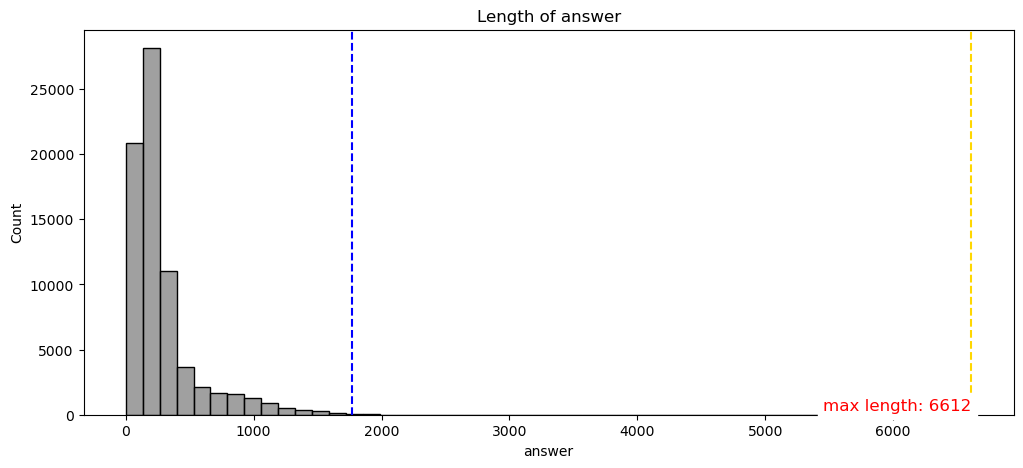

In [51]:
# answer 문장 길이 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.histplot(dataDF['answer'].apply(lambda x: len(x)), bins=50, color='gray')
plt.title('Length of answer')
# 맥스값 표시 : text도 함께 표시
plt.axvline(x=dataDF['answer'].apply(lambda x: len(x)).max(), color='gold', linestyle='--')
plt.text(dataDF['answer'].apply(lambda x: len(x)).max(), 100, 
         f"max length: {dataDF['answer'].apply(lambda x: len(x)).max()}", color='red', fontsize=12, va='bottom', ha='right', backgroundcolor='white')
# 문장 길이의 상위 98%값 표시
plt.axvline(x=dataDF['answer'].apply(lambda x: len(x)).quantile(0.999), color='blue', linestyle='--')
# plt.text(dataDF['answer'].apply(lambda x: len(x)).quantile(0.999), 100,   # 2406
#             f"99.9%: {dataDF['answer'].apply(lambda x: len(x)).quantile(0.9999)}", color='red', fontsize=12, va='bottom', ha='right', backgroundcolor='white')
plt.show()

Text(2503, 100, 'max length: 2503')

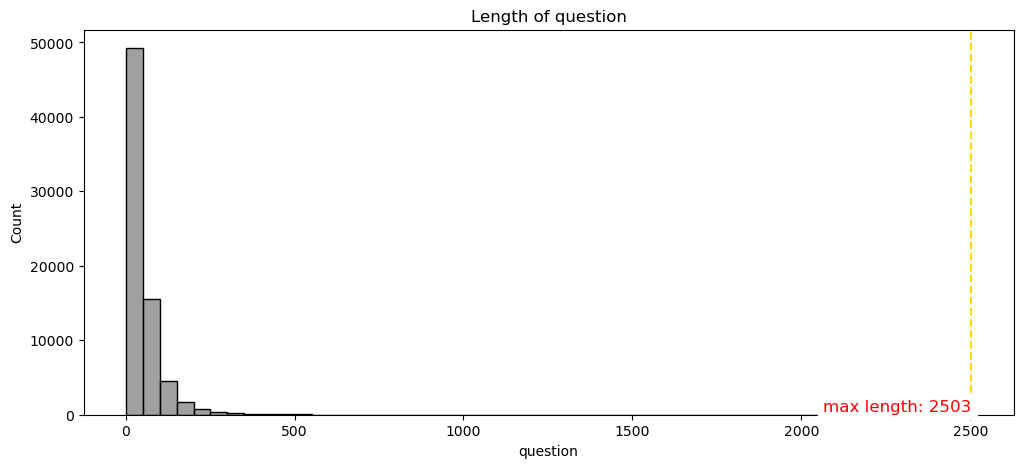

In [55]:
# answer 문장 길이 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.histplot(dataDF['question'].apply(lambda x: len(x.split())), bins=50, color='gray')
plt.title('Length of question')
# 맥스값 표시 : text도 함께 표시
plt.axvline(x=dataDF['question'].apply(lambda x: len(x.split())).max(), color='gold', linestyle='--')
plt.text(dataDF['question'].apply(lambda x: len(x.split())).max(), 100, 
         f"max length: {dataDF['question'].apply(lambda x: len(x.split())).max()}", color='red', fontsize=12, va='bottom', ha='right', backgroundcolor='white')

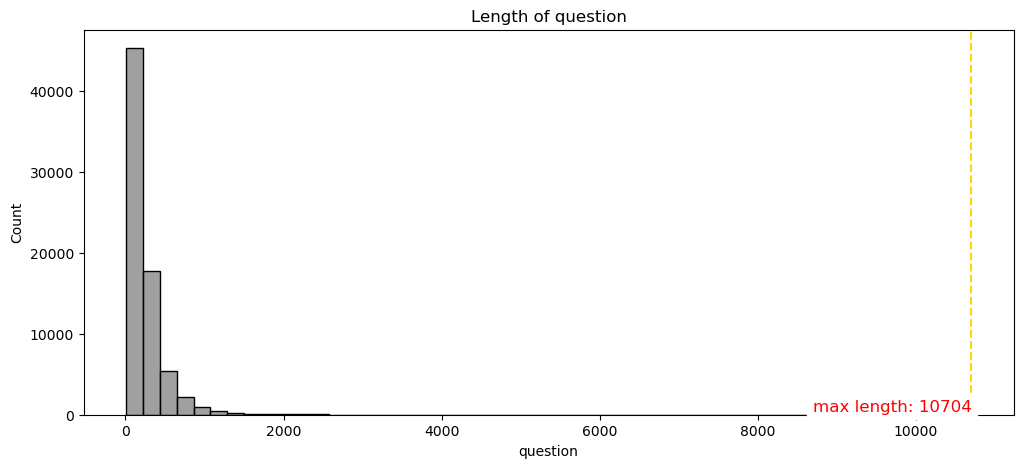

In [53]:
# question 문장 길이 분포 시각화
plt.figure(figsize=(12, 5))
sns.histplot(dataDF['question'].apply(lambda x: len(x)), bins=50, color='gray')
plt.title('Length of question')
# 맥스값 표시 : text도 함께 표시
plt.axvline(x=dataDF['question'].apply(lambda x: len(x)).max(), color='gold', linestyle='--')
plt.text(dataDF['question'].apply(lambda x: len(x)).max(), 100,
            f"max length: {dataDF['question'].apply(lambda x: len(x)).max()}", color='red', fontsize=12, va='bottom', ha='right', backgroundcolor='white')
# qutstion 문장 길이의 상위 98% 지점 표시
# plt.axvline(x=dataDF['question'].apply(lambda x: len(x)).quantile(0.99), color='blue', linestyle='--')  # 1238
plt.show()

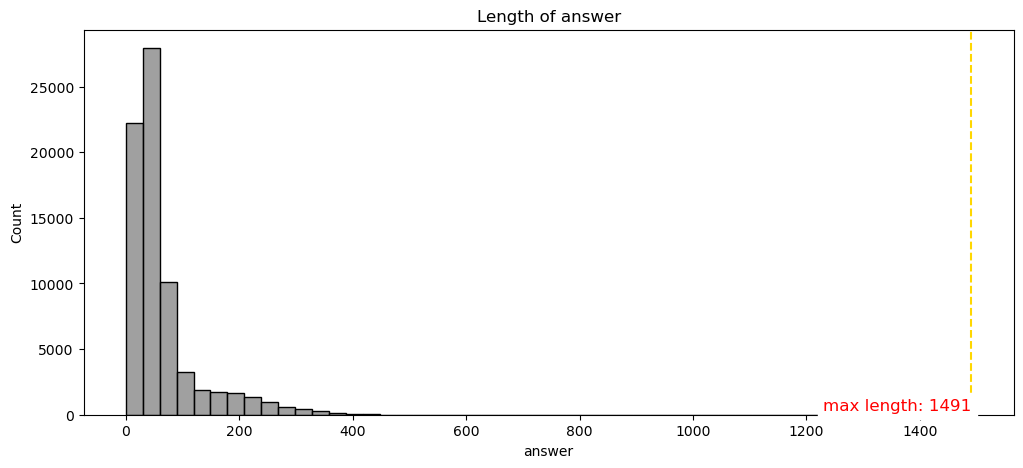

In [56]:
# answer 문장 길이 분포 시각화

plt.figure(figsize=(12, 5))
sns.histplot(dataDF['answer'].apply(lambda x: len(x.split())), bins=50, color='gray')
plt.title('Length of answer')
# 맥스값 표시 : text도 함께 표시
plt.axvline(x=dataDF['answer'].apply(lambda x: len(x.split())).max(), color='gold', linestyle='--')
plt.text(dataDF['answer'].apply(lambda x: len(x.split())).max(), 100, 
         f"max length: {dataDF['answer'].apply(lambda x: len(x.split())).max()}", color='red', fontsize=12, va='bottom', ha='right', backgroundcolor='white')
plt.show()

In [231]:
# 학습용 데이터셋 - 80%
train_data = dataDF.sample(frac=0.9, random_state=2021)
# 테스트용 데이터셋 - 20%
test_data = dataDF.drop(train_data.index)

In [232]:
# 스페셜 토큰 정의
Q_TKN = "<usr>"
A_TKN = "<sys>"
BOS = "</s>"
EOS = "</s>"
SENT = '<unused1>'
PAD = "<pad>"
MASK = "<unused0>"
UNK = '<unk>'
TOKENIZER = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2", bos_token=BOS, eos_token=EOS, unk_token=UNK, pad_token=PAD, mask_token=MASK,)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [233]:
class ChatbotDataset(Dataset):
    def __init__(self, DF):
        self.data = DF
        self.tokenizer = TOKENIZER

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        question = self.data['question'].iloc[idx]
        answer = self.data['answer'].iloc[idx]
        tokenizer = self.tokenizer

        # 질문과 답변을 토큰화하고 오프셋 계산
        q_tokens = tokenizer.tokenize(question)
        a_tokens = tokenizer.tokenize(answer)

        # 토큰을 인덱스로 변환
        q_input = tokenizer.convert_tokens_to_ids(q_tokens)
        a_input = tokenizer.convert_tokens_to_ids(a_tokens)

        # 오프셋 계산
        q_offsets = [(0, 0)] * len(q_input)
        a_offsets = [(0, 0)] * len(a_input)

        return q_input, q_offsets, a_input, a_offsets

In [234]:
class ChatbotDatasetWithOffsets(Dataset):
    def __init__(self, DF):
        self.data = DF
        self.tokenizer = TOKENIZER
        self.q_token = Q_TKN
        self.a_token = A_TKN
        self.sent_token = SENT
        self.bos_token = BOS
        self.eos_token = EOS
        self.mask_token = MASK

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        question = self.data['question'].iloc[idx]
        answer = self.data['answer'].iloc[idx]
        tokenizer = self.tokenizer

        q_tokenized = tokenizer.tokenize(self.q_token)
        a_tokenized = tokenizer.tokenize(self.a_token)
        sent_tokenized = tokenizer.tokenize(self.sent_token)
        bos_tokenized = tokenizer.tokenize(self.bos_token)
        eos_tokenized = tokenizer.tokenize(self.eos_token)

        question = tokenizer.tokenize(question)
        answer = tokenizer.tokenize(answer)

        q_input = q_tokenized + question + sent_tokenized + a_tokenized
        a_input = bos_tokenized + answer
        a_output = answer + eos_tokenized

        q_input_ids = tokenizer.convert_tokens_to_ids(q_input)
        a_input_ids = tokenizer.convert_tokens_to_ids(a_input)
        a_output_ids = tokenizer.convert_tokens_to_ids(a_output)

        # 입력 시퀀스의 마스크 생성
        q_mask = [1] * len(q_input_ids)
        a_mask = [1] * len(a_input_ids)

        # 입력 시퀀스의 오프셋 생성
        q_offsets = [0] * len(q_tokenized) + [1] * len(question) + [2] * len(sent_tokenized) + [3] * len(a_tokenized)
        a_offsets = [4] * len(bos_tokenized) + [5] * len(answer) + [6] * len(eos_tokenized)

        return q_input_ids, q_mask, q_offsets, a_input_ids, a_mask, a_offsets

def collate_fn_with_offsets(batch):
    # 각 배치에 있는 시퀀스들을 리스트로 추출합니다.
    q_input_ids, q_mask, q_offsets, a_input_ids, a_mask, a_offsets = zip(*batch)

    # 가장 긴 시퀀스의 길이를 찾습니다.
    max_seq_length = max(max(len(seq) for seq in q_input_ids), max(len(seq) for seq in a_input_ids))

    # 각 시퀀스의 길이를 최대 시퀀스 길이에 맞게 패딩합니다.
    q_input_ids_padded = [seq + [0] * (max_seq_length - len(seq)) for seq in q_input_ids]
    a_input_ids_padded = [seq + [0] * (max_seq_length - len(seq)) for seq in a_input_ids]
    q_mask_padded = [seq + [0] * (max_seq_length - len(seq)) for seq in q_mask]
    a_mask_padded = [seq + [0] * (max_seq_length - len(seq)) for seq in a_mask]
    q_offsets_padded = [offsets + [0] * (max_seq_length - len(offsets)) for offsets in q_offsets]
    a_offsets_padded = [offsets + [0] * (max_seq_length - len(offsets)) for offsets in a_offsets]

    # 텐서로 변환합니다.
    q_input_ids_tensor = torch.LongTensor(q_input_ids_padded)
    q_mask_tensor = torch.LongTensor(q_mask_padded)
    q_offsets_tensor = torch.LongTensor(q_offsets_padded)
    a_input_ids_tensor = torch.LongTensor(a_input_ids_padded)
    a_mask_tensor = torch.LongTensor(a_mask_padded)
    a_offsets_tensor = torch.LongTensor(a_offsets_padded)

    return q_input_ids_tensor, q_mask_tensor, q_offsets_tensor, a_input_ids_tensor, a_mask_tensor, a_offsets_tensor




In [235]:
# train 80%, val 20%
trainDS = ChatbotDataset(train_data)
validDS = ChatbotDataset(test_data)

In [236]:
trainDS_offset = ChatbotDatasetWithOffsets(train_data)
validDS_offset = ChatbotDatasetWithOffsets(test_data)

trainDL_offset = DataLoader(trainDS_offset, batch_size=8, shuffle=True, collate_fn=collate_fn_with_offsets)
validDL_offset = DataLoader(validDS_offset, batch_size=8, shuffle=False, collate_fn=collate_fn_with_offsets)

In [237]:
def collate_fn(batch):
    q_inputs, q_offsets, a_inputs, a_offsets = [], [], [], []
    for item in batch:
        q_inputs.append(item[0])
        q_offsets.append(item[1])
        a_inputs.append(item[2])
        a_offsets.append(item[3])
    return torch.LongTensor(q_inputs), torch.LongTensor(q_offsets), torch.LongTensor(a_inputs), torch.LongTensor(a_offsets)

In [238]:
# def collate_fn(batch):
#     source, labels, texts = zip(*batch)
#     tokenizd = TOKENIZER(texts, padding='longest', truncation=True, return_tensors='pt')
#     input_ids = tokenizd['input_ids'].to(DEVICE)
#     attentoion_mask = tokenizd['attention_mask'].to(DEVICE)
#     labels = torch.tensor(labels).to(DEVICE)
#     return input_ids, attentoion_mask, labels

In [239]:
TOKENIZER.pad_token = TOKENIZER.eos_token

In [240]:
trainDL = DataLoader(trainDS, batch_size=8, shuffle=True, collate_fn=collate_fn)
validDL = DataLoader(validDS, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [241]:
print('Train Dataset :', len(trainDS))
print('Valid Dataset :', len(validDS))

Train Dataset : 64570
Valid Dataset : 7174


In [242]:
model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")

In [243]:
CRITERION = torch.nn.CrossEntropyLoss(ignore_index=TOKENIZER.pad_token_id)
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 10000
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode='min', patience=5)

In [244]:
def calc_acc(pre, labels):
    pre = np.argmax(pre, axis=1).flatten()
    labels = labels.flatten()
    acc = np.sum(pre == labels) / len(labels)
    return acc

In [245]:
def training(model, dl):
    model.train()
    train_loss = 0.0

    for q_input_ids, q_mask, q_offsets, a_input_ids, a_mask, a_offsets in dl:
        model.zero_grad()

        # 모델 입력을 준비합니다.
        q_input_ids = q_input_ids.to(DEVICE)
        q_mask = q_mask.to(DEVICE)
        q_offsets = q_offsets.to(DEVICE)
        a_input_ids = a_input_ids.to(DEVICE)
        a_mask = a_mask.to(DEVICE)
        a_offsets = a_offsets.to(DEVICE)

        outputs = model(
            input_ids=q_input_ids,
            attention_mask=q_mask,
            encoder_offsets=q_offsets,  # 오프셋 정보를 전달합니다.
            decoder_input_ids=a_input_ids,
            decoder_attention_mask=a_mask,
            decoder_offsets=a_offsets  # 오프셋 정보를 전달합니다.
        )

        loss = outputs.loss
        loss.backward()
        OPTIMIZER.step()
        train_loss += loss.item()

    train_loss /= len(dl)
    return train_loss


In [246]:
# def training(model, dl):
#     model.train()
#     train_loss = 0.0

#     for input_ids, attention_mask, labels in dl:
#         model.zero_grad()
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         OPTIMIZER.step()
#         train_loss += loss.item()
#     trian_loss = train_loss / len(dl)
#     return train_loss

In [247]:
def testing(model, dl):
    with torch.no_grad():
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        for q_input_ids, q_mask, q_offsets, a_input_ids, a_mask, a_offsets, labels in dl:
            # 모델 입력을 준비합니다.
            q_input_ids = q_input_ids.to(DEVICE)
            q_mask = q_mask.to(DEVICE)
            q_offsets = q_offsets.to(DEVICE)
            a_input_ids = a_input_ids.to(DEVICE)
            a_mask = a_mask.to(DEVICE)
            a_offsets = a_offsets.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(
                input_ids=q_input_ids,
                attention_mask=q_mask,
                encoder_offsets=q_offsets,  # 오프셋 정보를 전달합니다.
                decoder_input_ids=a_input_ids,
                decoder_attention_mask=a_mask,
                decoder_offsets=a_offsets  # 오프셋 정보를 전달합니다.
            )

            loss = outputs.loss
            logits = outputs.logits

            # 손실과 정확도를 계산합니다.
            val_loss += loss.item()
            val_acc += calc_acc(logits.detach().cpu().numpy(), labels.detach().cpu().numpy())

        val_loss /= len(dl)
        val_acc /= len(dl)

    return val_loss, val_acc


In [248]:
# def testing(model, dl):
#     with torch.no_grad():
#         model.eval()
#         val_loss, val_acc = 0.0, 0.0

#         for input_ids, attention_mask, labels in dl:
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             logits = outputs.logits
            
#             loss = CRITERION(logits, labels)
#             logits = logits.detach().cpu().numpy()
#             labels = labels.to('cpu').numpy()
#             acc = calc_acc(logits, labels)

#             val_loss += loss
#             val_acc += acc

#         val_loss = val_loss / len(dl)
#         val_acc = val_acc / len(dl)
#     return val_loss, val_acc

In [249]:
min_loss = np.inf
train = []
valid = [[],[]]
for epoch in range(EPOCHS):
    train_loss = training(model, trainDL_offset)
    val_loss, val_acc = testing(model, validDL_offset)
    SCHEDULER.step(val_loss)
    train.append(train_loss)
    valid[0].append(val_loss)
    valid[1].append(val_acc)
    print(f'Epoch : {epoch+1} | Train Loss : {train_loss:.5f} | Valid Loss : {val_loss:.5f} | Valid Acc : {val_acc:.5f}')

    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), './model/my_chatbot.pth')
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
        break

TypeError: forward() got an unexpected keyword argument 'encoder_offsets'